<a href="https://colab.research.google.com/github/seungwoo-Jang/modu_quest/blob/main/Going%20Deeper%20(CV)_RS4/E04/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 [==============================] - 2s 2s/step


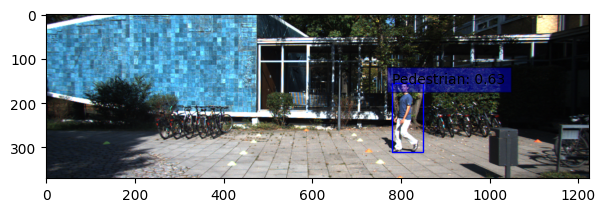

Stop
1/1 [==============================] - 0s 131ms/step


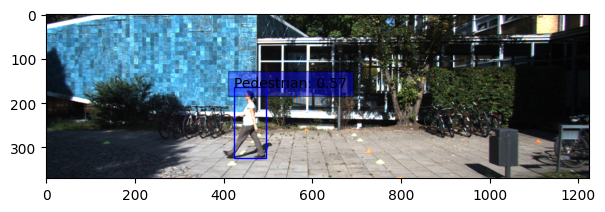

Stop
1/1 [==============================] - 0s 111ms/step


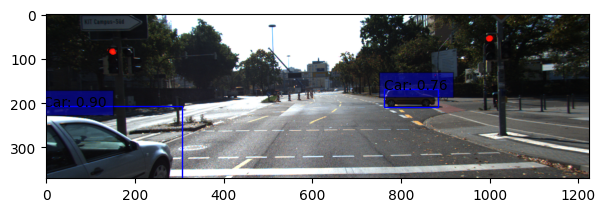

Stop
1/1 [==============================] - 0s 114ms/step


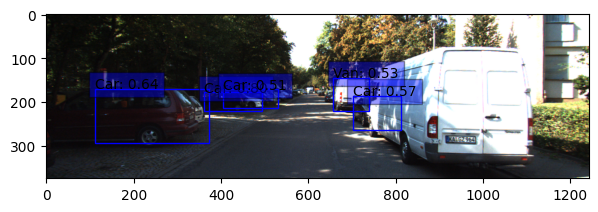

Stop
1/1 [==============================] - 0s 113ms/step


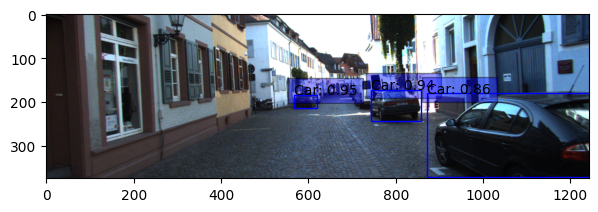

Stop
1/1 [==============================] - 0s 123ms/step


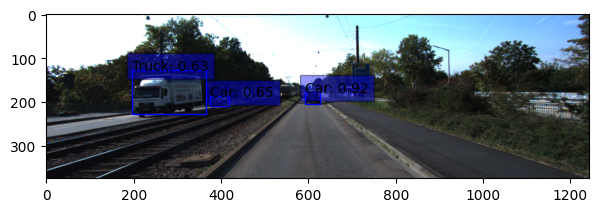

Go
1/1 [==============================] - 0s 113ms/step


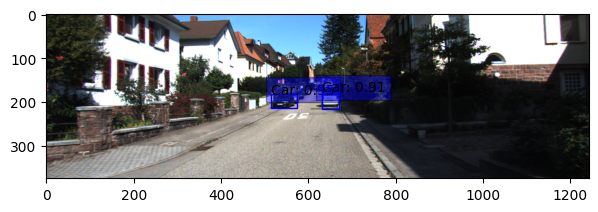

Go
1/1 [==============================] - 0s 109ms/step


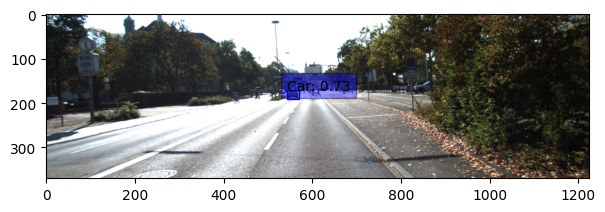

Go
1/1 [==============================] - 0s 141ms/step


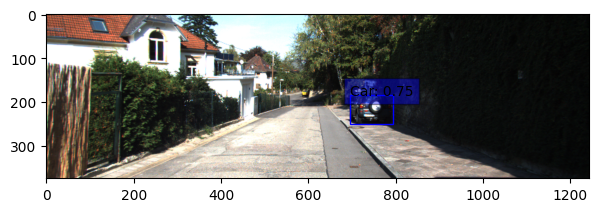

Go
1/1 [==============================] - 0s 135ms/step


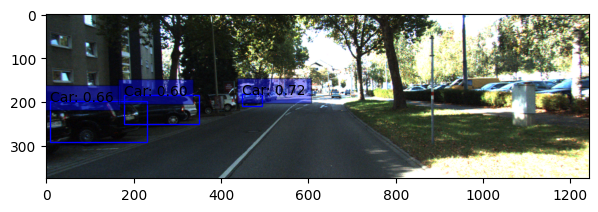

Go
100점입니다.


In [6]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

#데이터 전처리
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/saved_data'

(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

def resize_and_pad_image(image, training=True):
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape) #w,h중 작은 사이즈 기준으로 나누기
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape) #max값을 나눠도 크면 한 번 더 나누기
    image_shape = ratio * image_shape #이미지 사이즈 비율 곱하기
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32)) #비율로 곱한 이미지 사이즈로 변경
    padded_image_shape = tf.cast( # 패딩된 이미지의 크기를 stride의 배수로 만들기 위해 나눈값 올림해서 다시 곱하기
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box( #이미지에 패딩 입히기 / 이미지,offset-h,offset-w,h,w
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )# 우측, 하단으로 검은색 배경 확장
    return image, image_shape, ratio

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

int2str = dataset_info.features["objects"]["type"].int2str

#모델 정의
num_classes = 8
batch_size = 2

class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

def build_head(output_filters, bias_init): # 객체의 클래스와 위치 정보를 예측하는 역할
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

resnet50_backbone = get_backbone()
# loss_fn = RetinaNetLoss(num_classes) # 훈련을 별도로 돌리지 않을 예정
model = RetinaNet(num_classes, resnet50_backbone)

#앵커박스 및 디텍션 정의
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0] # 앵커박스 종횡비
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]] #앵커박스 크기

        self._num_anchors = len(self.aspect_ratios) * len(self.scales) #전체 앵커박스의 개수
        self._strides = [2 ** i for i in range(3, 8)] #피쳐맵의 스트라이드값
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]] #앵커박스 면적
        self._anchor_dims = self._compute_dims() #앵커박스 크기를 계산한 것

    def _compute_dims(self): #앵커박스 차원 계산
        anchor_dims_all = []
        for area in self._areas: #5개
            anchor_dims = []
            for ratio in self.aspect_ratios: #3개
                anchor_height = tf.math.sqrt(area / ratio) #앵커 높이
                anchor_width = area / anchor_height #앵커 너비
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2] #1,1,2 형태로 변경
                )
                for scale in self.scales: #3개
                    anchor_dims.append(scale * dims) #스케일 곱하기
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2)) #1,1,9,2
        return anchor_dims_all # 1,1,9,2가 5개

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        # rx를 가로방향, ry를 세로방향으로 반복하는 격자텐서 리턴, stride 비례해서 스케일링
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2) #앵커 개수 차원 만들기
        #중심 좌표를 복사하여 모든 anchor box에 대해 동일한 중심 좌표를 가지도록 만들기
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        #4는 중심 좌표(x, y)와 anchor box의 가로와 세로 차원
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8) # 3~7 레벨
        ]
        return tf.concat(anchors, axis=0)

def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1, #x,y,w,h
    ) # 왼쪽 위 모서리 좌표, 오른쪽 아래 모서리 좌표

class DecodePredictions(tf.keras.layers.Layer):
    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

# 디텍션 비쥬얼화
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    # plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

#모델 가중치 갖고오기
model_dir = '/content/drive/MyDrive/Colab Notebooks/saved_model/objects_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)


def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    image = Image.open(img_path)

    input_image, ratio = prepare_image(image)

    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

    for i in range(num_detections):
      # print(num_detections)
      w = detections.nmsed_boxes[0][i][2]/ratio - detections.nmsed_boxes[0][i][0]/ratio
      h = detections.nmsed_boxes[0][i][3]/ratio - detections.nmsed_boxes[0][i][1]/ratio
      # print(detections.nmsed_boxes[0][i][0]/ratio)
      # print(detections.nmsed_boxes[0][i][1]/ratio)
      # print(detections.nmsed_boxes[0][i][2]/ratio)
      # print(detections.nmsed_boxes[0][i][3]/ratio)
      # print(w*h)

      if 'Pedestrian' in class_names: #사람 있으면 멈추기
        print('Stop')
        return 'Stop'
      elif w*h >= 30000: #크기가 3만 넘으면 멈추기
        print('Stop')
        return 'Stop'
    print('Go')
    return 'Go'

def test_system(func):
    work_dir = '/content/drive/MyDrive/Colab Notebooks/saved_model/objects_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)



평가문항
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
 - KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.
 - 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.
 - 테스트 수행결과 90% 이상의 정확도를 보였다.

프로젝트 진행 관련 내용
 - training epoch 1 당 2~30분 소요되는 것으로 판단돼서 훈련은 진행하지 않고 가중치 갖고와서 사용
 - 모델 체크포인트 warning 메시지가 간헐적으로 발생하는데
   원인은 모델의 일부가 복원되지 않은 상태에서 모델을 삭제하거나 저장할 때 발생한다함
 - Stop,Go 결과는 중심부에서 앵커박스 크기로 판단하려했으나,
   빨간불 및 골목에서도 멈춰야하기 때문에 단순화하여 사람 여부 및 전체 앵커박스 크기로 기준을 지정